<a href="https://colab.research.google.com/github/BijoSebastian/grasp_it_repo/blob/main/grasp_planning_vanilla_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Applying Vanilla CNN, VGG-16, ResNet, InceptionNet(ViT if possible)
1. Dataloader:(Used this [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html))
*   Add all four channels of image into 1 RGBD image.
*   Get position and orientation from csv file and try to add it in one dataloader or figure out some other way.

2. Currently predicting only position and orientation of the gripper:
*  Loss function for orientation to be quaternions is custom made.
*  Total loss= (loss1)X(0.5) + (loss2)X(0.5)

In [1]:
#CustomDataLoader

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd

# Define custom dataset class
class RGBDDataset(Dataset):
    def __init__(self, rgb_dir, csv_file, depth_dir, transform=None):
        self.rgb_dir = rgb_dir
        self.depth_dir = depth_dir
        self.transform = transform

        # Get list of filenames in the directories
        self.rgb_files = sorted(os.listdir(rgb_dir))
        self.depth_files = sorted(os.listdir(depth_dir))

        # Ensure the number of RGB and depth images are the same
        assert len(self.rgb_files) == len(self.depth_files), "Number of RGB and depth images do not match"
        self.df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        # Load RGB and depth images
        rgb_path = os.path.join(self.rgb_dir, self.rgb_files[idx])
        depth_path = os.path.join(self.depth_dir, self.depth_files[idx])
        rgb_img = Image.open(rgb_path).convert('RGB')
        depth_img = Image.open(depth_path)
        #Converting depth images to (0,1) range
        depth_array = np.array(depth_img)
        scaled_depth_array = (depth_array - depth_array.min()) / (depth_array.max() - depth_array.min()+1e-8)
        depth_img = Image.fromarray(scaled_depth_array)


        # Apply transformations if specified
        if self.transform:
            rgb_img = self.transform(rgb_img)
            depth_img = self.transform(depth_img)

        # Combine RGB and depth images into RGBD
        rgbd_img = torch.cat((rgb_img, depth_img), dim=0)
        # Get position and orientation values for all five sets
        positions = []
        orientations = []
        for i in range(5):
            idx_values = self.df.iloc[idx * 5 + i]
            positions.append(torch.tensor(idx_values[['X', 'Y', 'Z']].values))
            orientations.append(torch.tensor(idx_values[['x_q', 'y_q', 'z_q', 'w_q']].values))

        positions = torch.stack(positions)  # Convert list of tensors to a single tensor
        orientations = torch.stack(orientations)  # Convert list of tensors to a single tensor

        return rgbd_img, positions, orientations


# Define transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to match input size of CNN architecture if required
    #transforms.CenterCrop(512), #if we want to use the exact image without losing aspect ratio
    transforms.ToTensor(),  # Convert images to tensors
])

# Initialize dataset
rgb_dir = '/content/drive/MyDrive/Masters_thesis/Dataset_1/dataset_1(depth=1,2)/rgb'
depth_dir = '/content/drive/MyDrive/Masters_thesis/Dataset_1/dataset_1(depth=1,2)/depth'
csv_file = '/content/drive/MyDrive/Masters_thesis/Dataset_1/merged_top_5_entries.csv'
dataset = RGBDDataset(rgb_dir,csv_file, depth_dir, transform=transform)

# Initialize DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Length of val dataset loader:{len(dataloader)}")
a,b,c = (next(iter(dataloader)))
print(a.shape)
print(b.shape)
print(c.shape)

Length of val dataset loader:143
torch.Size([16, 4, 512, 512])
torch.Size([16, 5, 3])
torch.Size([16, 5, 4])


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import pandas as pd
import torch

class YourClassName:  # Make sure to replace 'YourClassName' with the actual class name
    def __init__(self):
        self.df = pd.read_csv('/content/drive/MyDrive/Masters_thesis/Dataset_1/merged_top_5_entries.csv')

    def your_method_name(self, idx):
        positions = []
        orientations = []
        for i in range(5):
            idx_values = self.df.iloc[idx * 5 + i]
            positions.append(torch.tensor(idx_values[['X', 'Y', 'Z']].values))
            orientations.append(torch.tensor(idx_values[['x_q', 'y_q', 'z_q', 'w_q']].values))
        return positions, orientations

# Usage:
your_instance = YourClassName()
idx = 2000  # Example value for idx
positions, orientations = your_instance.your_method_name(idx)
print(positions)
print(orientations)


[tensor([-0.0057, -0.0916,  0.1387], dtype=torch.float64), tensor([-0.0105, -0.0661,  0.1243], dtype=torch.float64), tensor([-0.0631,  0.1167,  0.2778], dtype=torch.float64), tensor([-0.0239, -0.1040,  0.1898], dtype=torch.float64), tensor([-0.0046, -0.1293,  0.1048], dtype=torch.float64)]
[tensor([-0.0492,  0.9567, -0.2395,  0.1582], dtype=torch.float64), tensor([ 0.0534,  0.1872, -0.0268,  0.9805], dtype=torch.float64), tensor([ 0.8014,  0.0837,  0.1378, -0.5760], dtype=torch.float64), tensor([ 3.2528e-02,  9.7336e-01, -2.2695e-01, -6.2641e-04],
       dtype=torch.float64), tensor([-0.0118,  0.9868,  0.0361,  0.1577], dtype=torch.float64)]


#Visualization block to see if the images are correctly loaded

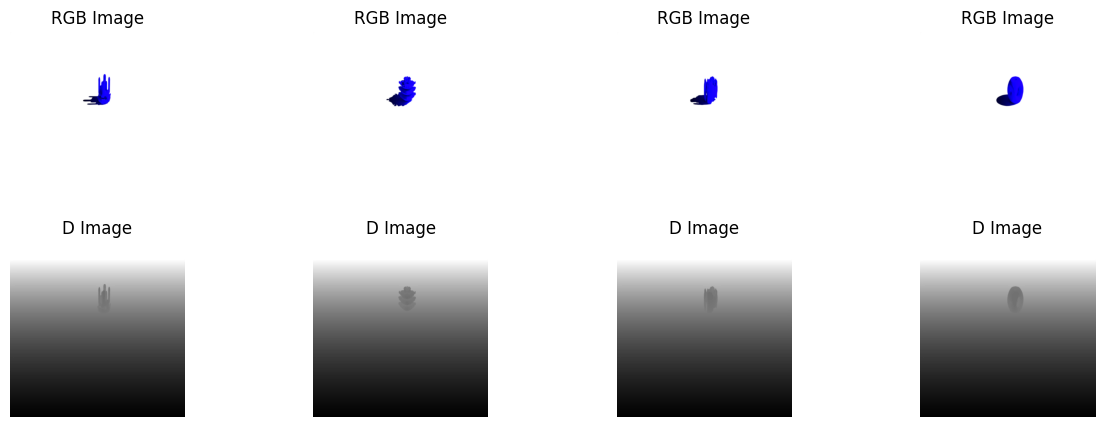

In [ ]:
import matplotlib.pyplot as plt

# Extract a batch of images from the dataloader
images_batch,  = next(iter(dataloader))

# Define the number of images to visualize
num_images = 4
# Plot the images
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

# Loop through the images in the batch
for i in range(num_images):
    # Extract the RGB and depth images from the batch
    rgb_img = images_batch[i, :3]  # RGB channels
    depth_img = images_batch[i, 3]  # Depth channel

    # Convert tensors to numpy arrays
    rgb_img_np = rgb_img.permute(1, 2, 0).cpu().numpy()  # Permute dimensions and convert to numpy array
    depth_img_np = depth_img.cpu().numpy()
    # Plot RGB image
    axes[0,i].imshow(rgb_img_np)
    axes[0,i].set_title('RGB Image')
    axes[0,i].axis('off')

    # Plot depth image
    axes[1,i].imshow(depth_img_np, cmap='gray', alpha=1)  # Overlay depth image with transparency
    axes[1,i].set_title('D Image')
    axes[1,i].axis('off')

plt.show()

#Helper functions:
* Loss functions
* Optimizer
* Accuracy function
* Maybe visualisation of results


In [ ]:
#Helper functions and Quaternion loss function
import torch
import torch.nn as nn

def quaternion_loss(q_actual, q_predicted):
    """
    Compute quaternion loss between actual and predicted quaternions.

    Args:
        q_actual (torch.Tensor): Actual quaternions (batch_size x num_outputs x 4).
        q_predicted (torch.Tensor): Predicted quaternions (batch_size x num_outputs x 4).

    Returns:
        torch.Tensor: Quaternion loss.
    """
    # Compute dot product
    dot_product = torch.sum(q_actual * q_predicted, dim=2)

    # Take absolute difference from 1
    loss = 1 - torch.abs(dot_product)

    return loss.mean()  # Return mean loss over the batch and number of outputs

# Example usage:
# Assuming positions and orientations are tensors of shape (batch_size, num_outputs, 3) and (batch_size, num_outputs, 4) respectively
position_criterion = nn.MSELoss()  # Mean Squared Error for position

# Calculate losses
position_loss = position_criterion(positions, actual_positions)
orientation_loss = quaternion_loss(orientations, actual_orientations)

# Total loss
total_loss = position_loss + orientation_loss

# Backward pass and optimization
optimizer.zero_grad()
total_loss.backward()
optimizer.step()


In [2]:
#Vanilla CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Position_Orientation(nn.Module):
    def __init__(self, num_outputs=5):
        super(CNN_Position_Orientation, self).__init__()
        self.num_outputs = num_outputs

        # Define convolutional layers for image processing
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Define fully connected layers for position prediction
        self.fc_position1 = nn.Linear(64 * 64 * 64, 512)
        self.fc_position2 = nn.Linear(512, 3 * num_outputs)  # Output 5 sets of 3D positions

        # Define fully connected layers for orientation prediction
        #self.fc_orientation1 = nn.Linear(64 * 32 * 32, 512)
        #self.fc_orientation2 = nn.Linear(512, 4 * num_outputs)  # Output 10 sets of quaternions

    def forward(self, x):
        # Forward pass through convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)

        # Position prediction
        position = F.relu(self.fc_position1(x))
        position = self.fc_position2(position)
        position = position.view(-1, self.num_outputs, 3)  # Reshape to (batch_size, num_outputs, 3)

        # Orientation prediction
        #orientation = F.relu(self.fc_orientation1(x))
        #orientation = self.fc_orientation2(orientation)
        #orientation = orientation.view(-1, self.num_outputs, 4)  # Reshape to (batch_size, num_outputs, 4)

        return position
import torch

def accuracy(predictions, targets, threshold=0.1):
    """
    Calculate the accuracy based on Euclidean distance between predictions and targets.

    Args:
    - predictions (torch.Tensor): Predicted positions (batch_size, num_outputs, 3).
    - targets (torch.Tensor): Actual positions (batch_size, num_outputs, 3).
    - threshold (float): Maximum allowed Euclidean distance for a prediction to be considered accurate.

    Returns:
    - accuracy (float): Percentage of accurate predictions.
    """
    batch_size, num_outputs, _ = predictions.size()
    num_correct = 0

    for i in range(batch_size):
        for j in range(num_outputs):
            pred = predictions[i, j]
            target = targets[i, j]
            distance = torch.norm(pred - target)  # Calculate Euclidean distance
            if distance <= threshold:
                num_correct += 1

    total_predictions = batch_size * num_outputs
    accuracy = (num_correct / total_predictions) * 100.0

    return accuracy
def calculate_accuracy(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_accuracy = 0.0

    with torch.no_grad():
        for rgbd_images, positions, orientations in dataloader:
            positions = positions.float()
            outputs = model(rgbd_images)
            batch_accuracy = accuracy(outputs, positions)  # Use the previously defined accuracy function
            total_accuracy += batch_accuracy

    model.train()  # Set the model back to training mode
    return total_accuracy / len(dataloader.dataset)  # Return average accuracy

# Example usage:
# Instantiate the model
model = CNN_Position_Orientation(num_outputs=5)

# Assuming rgb_d_image is your input RGBD image tensor of shape (batch_size, channels, height, width)
# Forward pass

positions = model(a)
print(positions.shape)
# positions shape: (batch_size, num_outputs, 3)
# orientations shape: (batch_size, num_outputs, 4)


torch.Size([16, 5, 3])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the training parameters
epochs = 10
learning_rate = 0.01

# Initialize the model, loss function, and optimizer
model = CNN_Position_Orientation(num_outputs=5)
position_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    for batch_idx, (rgbd_images, positions, orientations) in enumerate(dataloader):
        # Forward pass
        positions= positions.float()
        outputs = model(rgbd_images)

        # Compute the loss
        loss = position_criterion(outputs, positions)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print batch statistics
        total_loss += loss.item()
        if batch_idx % 10 == 9:  # Print every 10 batches
            print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, batch_idx+1, len(dataloader), total_loss / 10))
            total_loss = 0.0
        # Calculate accuracy after each epoch
    epoch_accuracy = calculate_accuracy(model, dataloader)
    print('Epoch [{}/{}], Accuracy: {:.2f}%'.format(epoch+1, epochs, epoch_accuracy))
    total_accuracy += epoch_accuracy

print('Training finished!')
